# Lab 2, Группа № 2371, Смирнов Максим Алексеевич
### Знакомство с методом кластеризации K-mean с помощью пакета sklearn  

Для выполнения задания используется набор данных из предыдущей лр.  

## 1. К текущему датасету необходимо добавить новый аттрибут  
Датасет содержит следующие столбцы:  
- `Date` — дата и время (тип данных: object).
- `Open, High, Low, Close` — цены открытия, максимальная, минимальная и закрытия за день (тип данных: float64).
- `Adj Close` — скорректированная цена закрытия (тип данных: float64).
- `Volume` — объем торгов (тип данных: int64).  

Приступим к добавлению нового атрибута.

In [10]:
import pandas as pd

# Загрузим данные из файла
data = pd.read_csv('bitcoin.csv')

# Выведем первые несколько строк и основные сведения о датасете
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17 00:00:00.000,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18 00:00:00.000,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19 00:00:00.000,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20 00:00:00.000,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21 00:00:00.000,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [22]:
# Добавим атрибут "Daily Change" (дневное изменение цены), как разность между "High" и "Low"
data['Daily Change'] = data['High'] - data['Low']

# Проверим, как выглядит датасет после добавления нового атрибута
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
0,2014-09-17 00:00:00.000,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,15.752014
1,2014-09-18 00:00:00.000,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,43.755981
2,2014-09-19 00:00:00.000,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,43.302978
3,2014-09-20 00:00:00.000,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,33.412994
4,2014-09-21 00:00:00.000,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,19.244995


## 2. "Причёсываем датасет"  
Дубликатов в датасете нет. При этом статистика показывает, что у нас есть значительные выбросы, особенно в столбцах `Volume` и `Daily Change`, где максимальные значения значительно превышают медианные и третьи квартили. Это может указывать на редкие события с экстремально высокими значениями объема торгов и дневного изменения цены.  

Для удаления выбросов мы можем использовать метод межквартильного размаха (IQR) или ограничить значения в пределах определенных границ. Применим метод **IQR**, чтобы удалить выбросы для столбцов `Volume` и `Daily Change`.  

In [24]:
# Проверим наличие дубликатов
duplicates_count = data.duplicated().sum()

# Выведем статистику для проверки выбросов и общей информации о данных
data_description = data.describe()

duplicates_count, data_description


(0,
                Open          High           Low         Close     Adj Close  \
 count   3228.000000   3228.000000   3228.000000   3228.000000   3228.000000   
 mean   13664.725548  13997.728538  13300.725867  13672.568197  13672.568197   
 std    16018.010041  16418.141665  15561.618968  16015.763332  16015.763332   
 min      176.897003    211.731003    171.509995    178.102997    178.102997   
 25%      762.625244    773.658493    750.296265    764.113251    764.113251   
 50%     7688.712403   7915.482666   7511.864746   7697.924072   7697.924072   
 75%    20282.866699  20754.581543  19902.022949  20297.028808  20297.028808   
 max    67549.734375  68789.625000  66382.062500  67566.828125  67566.828125   
 
              Volume  Daily Change  
 count  3.228000e+03   3228.000000  
 mean   1.656613e+10    697.002671  
 std    1.949084e+10   1118.777033  
 min    5.914570e+06      1.028000  
 25%    1.304910e+08     28.413765  
 50%    1.019161e+10    250.804199  
 75%    2.74277

In [36]:
# Для корректного отображения столбца Volume
pd.options.display.float_format = '{:,.0f}'.format  # Отображение чисел без десятичных знаков и научной нотации

# Удаление выбросов с использованием метода IQR для столбцов Volume и Daily Change
Q1 = data[['Volume', 'Daily Change']].quantile(0.25)
Q3 = data[['Volume', 'Daily Change']].quantile(0.75)
IQR = Q3 - Q1

# Фильтрация данных: оставляем значения в пределах [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
filtered_data = data[~((data[['Volume', 'Daily Change']] < (Q1 - 1.5 * IQR)) | 
                      (data[['Volume', 'Daily Change']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Выводим количество удалённых строк и описание данных после фильтрации
removed_rows = len(data) - len(filtered_data)
print(f"Количество удалённых строк: {removed_rows}")
filtered_data.describe()


Количество удалённых строк: 340


,Open,High,Low,Close,Adj Close,Volume,Daily Change
count,"2,888","2,888","2,888","2,888","2,888","2,888","2,888"
mean,"10,215","10,407","10,020","10,223","10,223","12,659,047,796",387
std,"12,365","12,557","12,163","12,364","12,364","14,197,088,968",480
min,177,212,172,178,178,"5,914,570",1
25%,642,656,636,646,646,"88,647,504",20
50%,"6,633","6,770","6,535","6,640","6,640","6,097,681,204",196
75%,"11,900","12,146","11,658","11,923","11,923","22,779,773,256",553
max,"64,979","65,579","64,180","65,467","65,467","66,964,629,541","2,018"


## 3. Построение графиков зависимости переменных  

- Volume и Daily Change — посмотрим на зависимость между объемом торгов и дневным изменением цены.
- Open и Close — проверим, как цена открытия и закрытия соотносятся.
- Date и Close — добавим временную ось, чтобы выявить тренды или аномальные группы


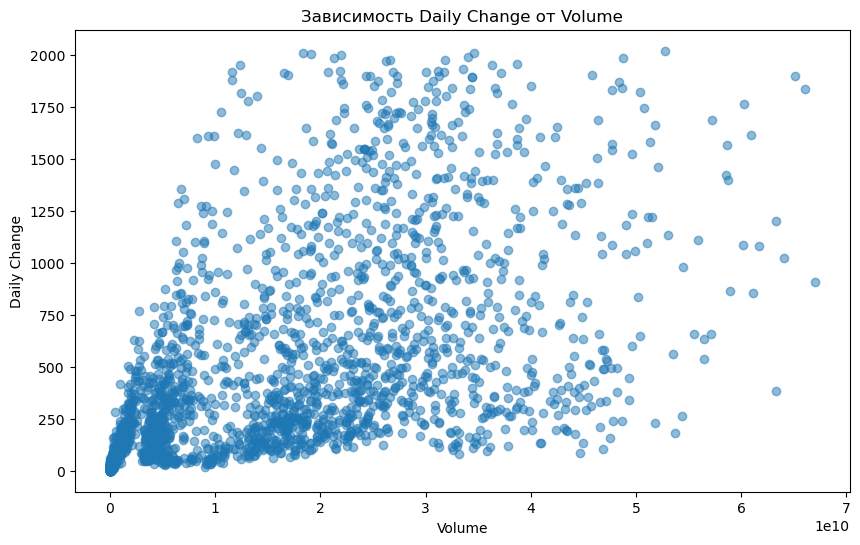

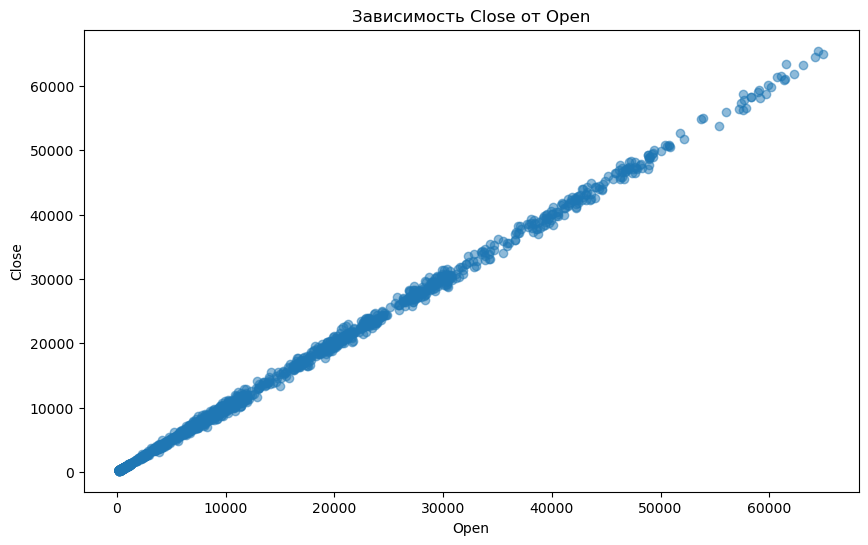

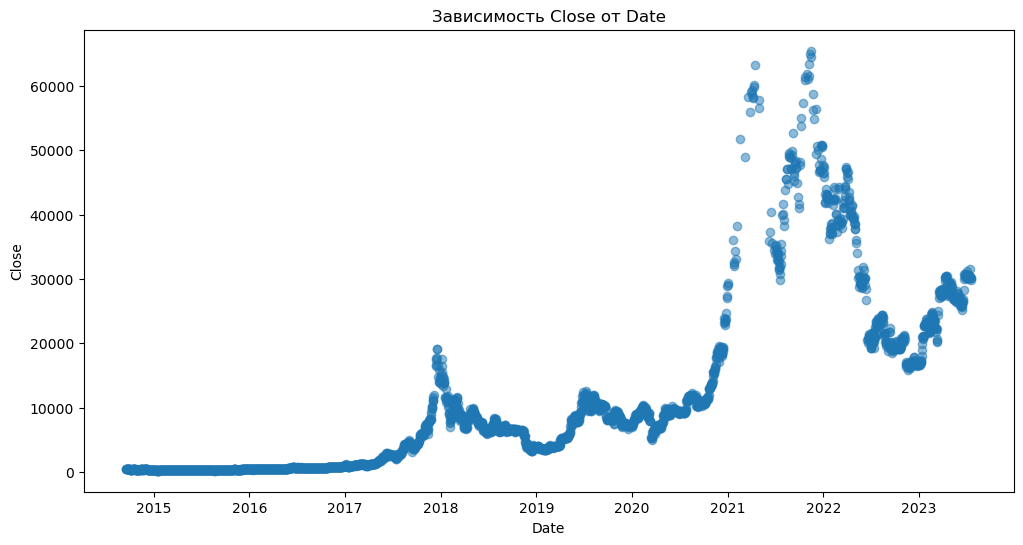

In [49]:
import matplotlib.pyplot as plt

# Убедимся, что 'Date' распознана как дата
# Во избежании ошибки, связанной с тем, что при изменении данных в переменной filtered_data
# Pandas предполагает, что это может быть не полностью независимая копия, а "вид" (view) на исходный DataFrame data.
filtered_data.loc[:, 'Date'] = pd.to_datetime(filtered_data['Date'])

# Построим график зависимости объема торгов от дневного изменения цены
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Volume'], filtered_data['Daily Change'], alpha=0.5)
plt.title('Зависимость Daily Change от Volume')
plt.xlabel('Volume')
plt.ylabel('Daily Change')
plt.show()

# Построим график зависимости цены закрытия от цены открытия
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Open'], filtered_data['Close'], alpha=0.5)
plt.title('Зависимость Close от Open')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

# Построим график цены закрытия от даты
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data['Date'], filtered_data['Close'], alpha=0.5)
plt.title('Зависимость Close от Date')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()


## 4. Применение метода KMeans  
**1.** Выберем для кластеризации несколько признаков, например:  
- `Volume` и `Daily Change` (чтобы группировать данные по объему торгов и изменению цены).
- `Open` и `Close` (чтобы увидеть, как распределяются кластеры по ценам открытия и закрытия).

**2.** Настроим и применим алгоритм KMeans, чтобы выявить кластеры. Начнем с выбора, например, 3 кластеров.  
**3.** Добавим метки кластеров к исходным данным и визуализируем кластеры на графиках.

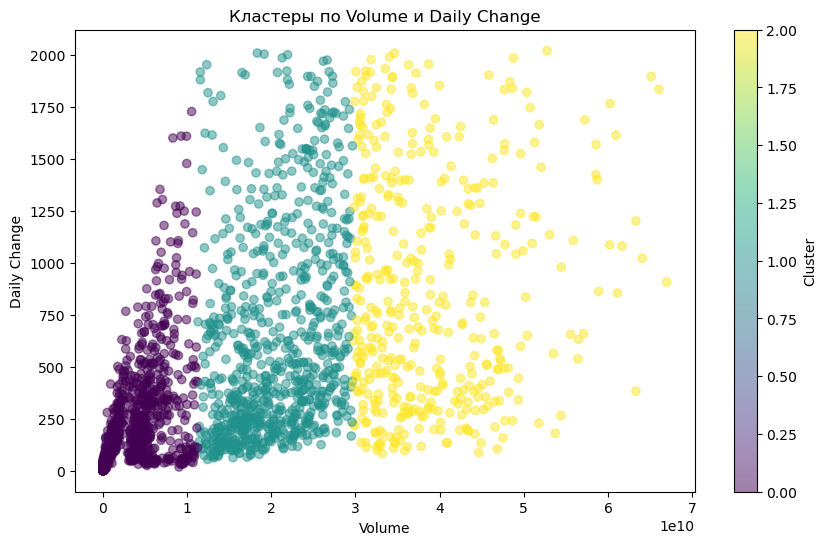

In [57]:
# Кластеризация KMeans
from sklearn.cluster import KMeans

# Выбор признаков для кластеризации
X = filtered_data[['Volume', 'Daily Change']]

# Инициализация и обучение модели KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
filtered_data.loc[:, 'Cluster'] = kmeans.fit_predict(X)  # Используем loc для добавления нового столбца

# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Volume'], filtered_data['Daily Change'], c=filtered_data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Кластеры по Volume и Daily Change')
plt.xlabel('Volume')
plt.ylabel('Daily Change')
plt.colorbar(label='Cluster')
plt.show()



## 5. Выводы  

Новый атрибут: Был добавлен атрибут "Daily Change", представляющий разницу между максимальной и минимальной ценой за день, что позволило понять колебания рынка.  

Очистка данных: Данные не содержали дубликатов и пропущенных значений, что упростило их подготовку. Проверка на выбросы была выполнена визуально на графиках  

Кластеризация: Метод KMeans с тремя кластерами показал распределение данных и помог выделить разные сегменты торговой активности. Кластеры различались по комбинации цены закрытия, объема торговли и дневного изменения цены.  

Данный подход позволяет выявить различия в торговой активности и волатильности, что может быть полезным для дальнейшего анализа или прогнозирования на рынке криптовалют..